<div>
    <h1>Assignment</h1>
    <ol>
<li>First make your own N data set from the given image</li>
<li>Make 2 di-mensional data from 5 dimensional data using PCA. (Non-Kernel 20pts, Kernel20pts)</li>
<li>Plot the projected 2 dimensional data on the 2 dimensional space.(10pts) </li>
<li>Cluster the projected 2 dimensional data (10pts)</li>
<li>Given the clustered data, apply segmentation of the image. (10pts)</li>
<li>Return 5 dimen-sional data from the 2 dimensional data using inverse PCA. (30pts)</li>
    </ol>
</div>

<div>
(609,960,3) #원본이미지 shape - h,w,rgb <br />
(609,960,5) #x,y추가 <br />
(584640, 5) # (N, 5)  <br />
    <br />
====PCA=====<br />
    <br />
(584640, 2) #축소된 데이터 형태<br />
    <br />
==KMeans(k=3 [임의])==<br />
    <br />
projected datapoint를 군집화 <br />
    <br />
==img segmentation==<br />
    <br />
클러스터 라벨에 따라 pixel 분할<br />
    <br />
==inverse PCA==<br />
    <br />
(584640, 5) #Reconstruct, inverse_scale<br />
</div>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

image shape: (609, 960, 3)


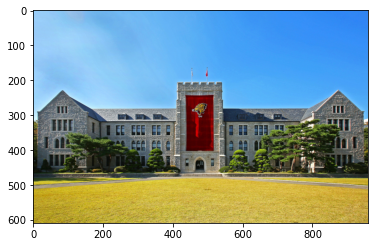

In [2]:
#1
img = plt.imread('./KU_image.jpeg')
plt.imshow(img)
print('image shape:',img.shape)

In [8]:
xy = [[x,y] for x in range(960) for y in range(609)]
xy = np.array(xy)
print(xy[0],xy.shape)

[0 0] (584640, 2)


In [51]:
img_5dim = np.concatenate((img.reshape(-1,3), xy),axis=1)
img_df = pd.DataFrame(img_5dim, columns=['red','green','blue','x','y'])
img_df

,red,green,blue,x,y
0,154,209,248,0,0
1,156,211,250,0,1
2,152,210,250,0,2
3,154,208,252,0,3
4,155,209,253,0,4
...,...,...,...,...,...
584635,205,162,70,959,604
584636,195,151,52,959,605
584637,214,180,73,959,606
584638,166,138,31,959,607


In [63]:
# 0-300 height = 'sky', 300-500 height = 'building', 500-608 height='ground'
img_df['labels'] = ''

def assign_label(i):
    if i >= 0 and i < 300:
        return 'sky'
    if i >= 300 and i < 500:
        return 'building'
    if i >= 500 and i <= 608:
        return 'ground'


In [64]:
img_df['labels'] = img_df['y'].apply(assign_label)
img_df

,red,green,blue,x,y,label,labels
0,154,209,248,0,0,sky,sky
1,156,211,250,0,1,sky,sky
2,152,210,250,0,2,sky,sky
3,154,208,252,0,3,sky,sky
4,155,209,253,0,4,sky,sky
...,...,...,...,...,...,...,...
584635,205,162,70,959,604,0,ground
584636,195,151,52,959,605,0,ground
584637,214,180,73,959,606,0,ground
584638,166,138,31,959,607,0,ground


In [119]:
def pca_sk(x):
    #1. normalize data
    scaler = StandardScaler()
    norm_x = scaler.fit_transform(x)
    
    #2. covariate matrix
    cov_mat = np.cov(norm_x.T)
    
    #3. eigenval, eigenvec
    eig_val, eig_vec = np.linalg.eig(cov_mat)
    print('first pc',eig_val[0] / sum(eig_val)) #explained variance ratio for pc 1
    print('second pc',eig_val[1] / sum(eig_val))
    
    #4. sort eigvec by decreasing eigval (big eigval = big distance = big variance)
    order = eig_val.argsort()[::-1]
    eig_vec = eig_vec[:,order]
    
    #5. select k number of pc
    eig_vec = eig_vec[:,:2]
    print('2 eig vec',eig_vec.shape)
    
    #6. project data to subspace 
    projected_x = norm_x.dot(eig_vec)
    print('Project {} dimensions to {} dimensions.'.format(norm_x.shape[1], projected_x.shape[1]))
    return projected_x

In [120]:
features = ['red','green','blue','x','y']
#features = ['red','green','blue']
x = img_df.loc[:,features].values
pj = pca_sk(x)
pj.shape

first pc 0.4297401431546421
second pc 0.34349147944024805
2 eig vec (5, 2)
Project 5 dimensions to 2 dimensions.


(584640, 2)

In [121]:
pc12_df = pd.DataFrame(pj, columns=['pc1','pc2'])
pca_df = pd.concat([pc12_df,img_df['labels']], axis=1)
pca_df

,pc1,pc2,labels
0,-2.213252,-0.439783,sky
1,-2.242796,-0.483983,sky
2,-2.236804,-0.423743,sky
3,-2.233908,-0.428451,sky
4,-2.248680,-0.450552,sky
...,...,...,...
584635,1.489078,-1.919399,ground
584636,1.702450,-1.691455,ground
584637,1.326286,-2.209351,ground
584638,1.943555,-1.205612,ground


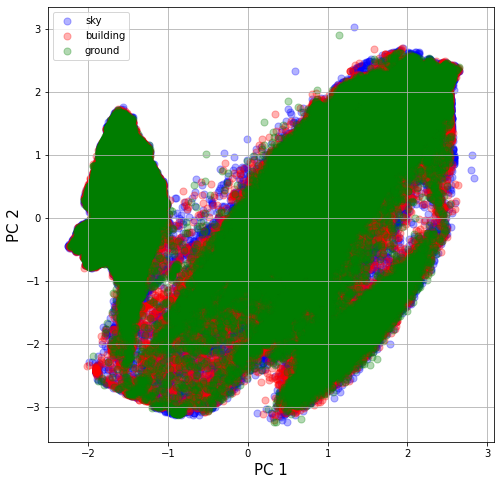

In [122]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
targets = ['sky', 'building', 'ground']
colors = ['b', 'r', 'g']

for target, color in zip(targets,colors):
    indicesToKeep = pca_df['labels'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'pc1']
               , pca_df.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 50
               , alpha = 0.3)
ax.legend(targets)
ax.grid()

In [123]:
#kmeans clustering
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(pj)
cluster_idx = kmeans.predict(pj)
cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_
kmeans_df = pd.DataFrame({'pc1':pj[:,0],'pc2':pj[:,1],'cluster':cluster_idx})
kmeans_df

,pc1,pc2,cluster
0,-2.213252,-0.439783,0
1,-2.242796,-0.483983,0
2,-2.236804,-0.423743,0
3,-2.233908,-0.428451,0
4,-2.248680,-0.450552,0
...,...,...,...
584635,1.489078,-1.919399,2
584636,1.702450,-1.691455,2
584637,1.326286,-2.209351,2
584638,1.943555,-1.205612,2


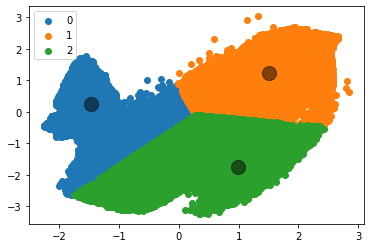

In [124]:
for i in range(3):
    plt.scatter(kmeans_df[kmeans_df['cluster']==i]['pc1'], kmeans_df[kmeans_df['cluster']==i]['pc2'] , label = i)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', s=200, alpha=0.5)    
plt.legend()
plt.show()

In [125]:
centers = np.uint8(cluster_centers)
segment = centers[cluster_labels] #converts each label array item to cluster_center value (idx)
print(segment.shape) 
print(centers)
print(segment[:-10])

(584640, 2)
[[255   0]
 [  1   1]
 [  0 255]]
[[255   0]
 [255   0]
 [255   0]
 ...
 [  0 255]
 [  0 255]
 [  0 255]]


In [126]:
padding = np.zeros((segment.shape[0],segment.shape[1]+1))
padding[:,:-1] = segment #added 0 as 3rd elm to each row
pc_rgb = padding.astype(int) 
pc_rgb[:-10]

array([[255,   0,   0],
       [255,   0,   0],
       [255,   0,   0],
       ...,
       [  0, 255,   0],
       [  0, 255,   0],
       [  0, 255,   0]])

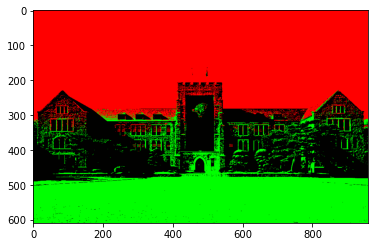

In [127]:
plt.imshow(pc_rgb.reshape(609,960,3))

In [65]:
#pca - sklearn 
# def pca_sk(x):
#     scaler = StandardScaler()
#     norm_x = scaler.fit_transform(x)
#     pca = PCA(n_components=2)
#     x_pca = pca.fit_transform(norm_x)
#     print('pca components,', pca.components_)
#     print('pca explained variance,', pca.explained_variance_)
#     print('pca explained variance ratio,',pca.explained_variance_ratio_)
#     print('original dimension {}, reduced dimension {}'.format(norm_x.shape, x_pca.shape))
#     return x_pca